In [3]:
import numpy as np
import torch
import itertools
from torch import nn
import copy
from tqdm import tqdm

In [1]:
import math
import numpy as np

def lz_complexity(s):
    i, k, l = 0, 1, 1
    k_max = 1
    n = len(s) - 1
    c = 1
    while True:
        if s[i + k - 1] == s[l + k - 1]:
            k = k + 1
            if l + k >= n - 1:
                c = c + 1
                break
        else:
            if k > k_max:
                k_max = k
            i = i + 1
            if i == l:
                c = c + 1
                l = l + k_max
                if l + 1 > n:
                    break
                else:
                    i = 0
                    k = 1
                    k_max = 1
            else:
                k = 1
    return c

def decimal(x):
    n = len(x)
    output = 0
    for i in range(len(x)):
        output += x[i]*2**(n-1-i)
    return output

def K_lemp_ziv(sequence):
    if (np.sum(sequence == 0) == len(sequence)) or (np.sum(sequence == 1) == len(sequence)) :

        out = math.log2(len(sequence))
    else:
        forward = sequence
        backward = sequence[::-1]

        out = math.log2(len(sequence))*(lz_complexity(forward) + lz_complexity(backward))/2

    return out

In [4]:
dim = 7
inputs = [[0, 1] for _ in range(dim)]
inputs = itertools.product(*inputs)
inputs = [i for i in inputs]
data = torch.Tensor(np.array(inputs))

In [5]:
class SimpleNN(nn.Module):
    def __init__(self, nl=2):
        super(SimpleNN, self).__init__()
        # self.flatten = nn.Flatten()
        self.nl = nl
        self.fc1 = nn.Linear(dim, 128, bias=False)
        self.relu = nn.ReLU()
        self.fcs = [nn.Linear(128, 128, bias=False) for _ in range(self.nl-1)]

        # self.relu = nn.Tanh()
        self.fc2 = nn.Linear(128, 1, bias=False)

    def forward(self, x):
        # x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        if self.nl>1:
            for fc in self.fcs:
                x = fc(x)
                x = self.relu(x)
        x = self.fc2(x)
        return x

In [16]:
net = SimpleNN(nl=4)

resolution = 20
total = 100
data_out = {}
layer = net.fc1
center = False

@torch.no_grad()
def main(data_out):
    x_ax = torch.randn_like(layer.weight)
    y_ax = torch.randn_like(layer.weight)

    subyx = float(torch.sum(x_ax*y_ax) / (torch.sqrt(torch.sum(x_ax**2)) *torch.sqrt(torch.sum(y_ax**2))  ))
    y_ax = y_ax - subyx * x_ax
    y_ax = y_ax / torch.norm(y_ax) * torch.norm(x_ax)

    raw = copy.deepcopy(layer.weight)

    if center:
        subx = float(torch.sum(x_ax*layer.weight) / torch.sqrt(torch.sum(x_ax**2))  / torch.sqrt(torch.sum(layer.weight**2))     )
        suby = float(torch.sum(y_ax*layer.weight) / torch.sqrt(torch.sum(y_ax**2))/ torch.sqrt(torch.sum(layer.weight**2))  )
        layer.weight += (-1* subx * x_ax -1* suby * y_ax)

    for i, j in tqdm(itertools.product(range(-total, total), range(-total, total)), total=4*total**2):
        layer.weight += x_ax * i * (1/resolution/layer.weight.shape[1]) + y_ax * j * (1/resolution/layer.weight.shape[1])
        y = net(data)
        y_str = "".join(["1" if float(k)>0 else "0" for k in y.reshape(-1)])
        data_out[(i* (1/resolution/layer.weight.shape[1]),j* (1/resolution/layer.weight.shape[1]))]=y_str
        layer.weight = copy.deepcopy(raw)
    return data_out

data_out = main(data_out)
print(data_out)

100%|██████████| 40000/40000 [02:23<00:00, 279.56it/s]

{(-0.7142857142857143, -0.7142857142857143): '00000000000000000000000000001000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000', (-0.7142857142857143, -0.7071428571428572): '00000000000000000000000000001000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000', (-0.7142857142857143, -0.7000000000000001): '00000000000000000000000000001000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000', (-0.7142857142857143, -0.692857142857143): '00000000000000000000000000001000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000', (-0.7142857142857143, -0.6857142857142857): '00000000000000000000000000001000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000', (-0.7142857142857143, -0.6785714285714286): '000000000000000000000000000010000000000000000000000010000000000000000000000

/tmp/ipykernel_3705215/1014364653.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('viridis', len(unique_strings))
/tmp/ipykernel_3705215/1014364653.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, c=point_colors, s=100, linewidths=1, cmap='viridis', marker='s')


Text(0.5, 1.0, '4364 unique functions')

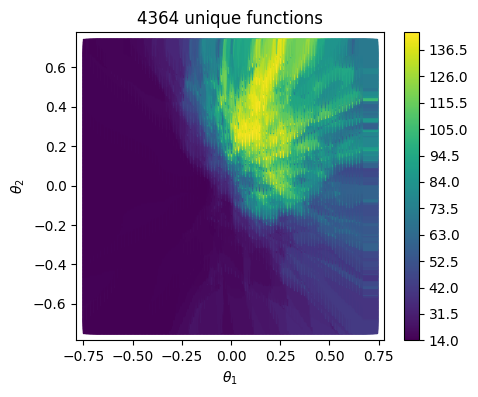

In [17]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
# from complexities2 import K_lemp_ziv

unique_strings = list(set(data_out.values()))
unique_strings_lz = {i:K_lemp_ziv(i) for i in unique_strings}
unique_strings_lz = {k: v for k, v in sorted(unique_strings_lz.items(), key=lambda item: item[1])}
unique_strings = list(unique_strings_lz.keys())
color_map = plt.cm.get_cmap('viridis', len(unique_strings))
colors = [color_map(i) for i in range(len(unique_strings))]
string_color_dict = dict(zip(unique_strings, colors))
string_color_dict_lz = dict(zip([K_lemp_ziv(i) for i in unique_strings], colors))

# Extract coordinates and corresponding strings
coordinates, strings = zip(*data_out.items())

# Map string to color
point_colors = [string_color_dict[string] for string in strings]

# Unpack coordinates
x, y = zip(*coordinates)

fig, ax = plt.subplots()

# Create scatter plot
scatter = ax.scatter(x, y, c=point_colors, s=100, linewidths=1, cmap='viridis', marker='s')

# Add legend
# legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=string) for string, color in string_color_dict_lz.items()]
# plt.legend(handles=legend_elements, loc='upper right')

cbar = plt.colorbar(scatter, ax=ax)

colours = [color for lz, color in string_color_dict_lz.items()]
lz = [lz for lz, color in string_color_dict_lz.items()]

num=len(colours)
if num > 10:
    skip = num // 10
cbar.set_ticks([i/(num-1) for i in range(num)][::skip])
cbar.set_ticklabels(lz[::skip])

# Show the plot
# fig.set_size_inches(10,10)
ax.set_box_aspect(1)
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
# ax.set_yticks([-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3])
# ax.set_xticks([-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3])
fig.set_size_inches(5,4)
ax.set_title(f'{len(string_color_dict)} unique functions')
# plt.savefig('wow.png', bbox_inches='tight', dpi=300)

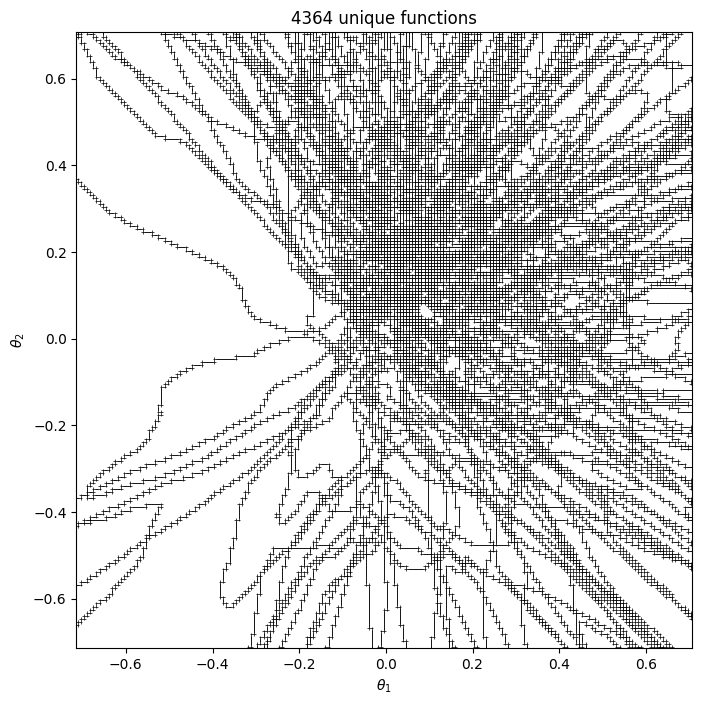

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def detect_function_boundaries(data_out):
    # Convert coordinates to a grid format
    coords = np.array(list(data_out.keys()))
    x_unique = np.sort(np.unique(coords[:, 0]))
    y_unique = np.sort(np.unique(coords[:, 1]))
    
    # Create grid of function values
    grid = np.zeros((len(y_unique), len(x_unique)), dtype=object)
    for (x, y), val in data_out.items():
        i = np.where(y_unique == y)[0][0]
        j = np.where(x_unique == x)[0][0]
        grid[i, j] = val
    
    # Initialize boundary segments
    segments = []
    
    # Detect vertical boundaries (comparing horizontal neighbors)
    for i in range(len(y_unique)):
        for j in range(len(x_unique)-1):
            if grid[i,j] != grid[i,j+1]:
                x_mid = (x_unique[j] + x_unique[j+1]) / 2
                segments.append([(x_mid, y_unique[i-1] if i > 0 else y_unique[i]), 
                               (x_mid, y_unique[i+1] if i < len(y_unique)-1 else y_unique[i])])
    
    # Detect horizontal boundaries (comparing vertical neighbors)
    for i in range(len(y_unique)-1):
        for j in range(len(x_unique)):
            if grid[i,j] != grid[i+1,j]:
                y_mid = (y_unique[i] + y_unique[i+1]) / 2
                segments.append([(x_unique[j-1] if j > 0 else x_unique[j], y_mid),
                               (x_unique[j+1] if j < len(x_unique)-1 else x_unique[j], y_mid)])
    
    return segments

def plot_function_boundaries(data_out):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Get boundary segments
    segments = detect_function_boundaries(data_out)
    
    # Create line collection for efficient plotting
    lc = LineCollection(segments, colors='black', linewidths=0.5)
    ax.add_collection(lc)
    
    # Set plot limits based on data
    coords = np.array(list(data_out.keys()))
    ax.set_xlim(coords[:,0].min(), coords[:,0].max())
    ax.set_ylim(coords[:,1].min(), coords[:,1].max())
    
    # Set labels and title
    ax.set_xlabel(r'$\theta_1$')
    ax.set_ylabel(r'$\theta_2$')
    ax.set_title(f'{len(set(data_out.values()))} unique functions')
    
    # Set aspect ratio
    ax.set_box_aspect(1)
    
    return fig, ax

# Usage:
fig, ax = plot_function_boundaries(data_out)
plt.show()